# Test №1 

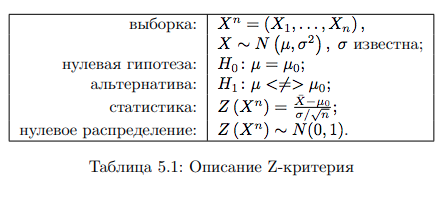
Уровень кальция в крови здоровых молодых женщин равен в среднем 9.5 милиграммам на децилитр и имеет характерное стандартное отклонение 0.4 мг/дл. В сельской больнице Гватемалы для 160 здоровых беременных женщин при первом обращении для ведения беременности был измерен уровень кальция; среднее значение составило 9.57 мг/дл. Можно ли утверждать, что средний уровень кальция в этой популяции отличается от 9.5?

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels
from statsmodels.stats.weightstats import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
z = (9.57 - 9.5) / (0.4 / np.sqrt(160))
print(round(2 * (1 - stats.norm.cdf(z)),4))

0.0269


Пояснение: stats.norm.cdf(z) возвращает значение плотность в точке. Т.к нас нужные хвосты, то надо смотреть 1 - stats.norm.cdf(z), а т.к. рассматривается двусторонняя альтернатива => умножаем на 2

In [3]:
data = pd.read_csv('diamonds.txt', sep='\t')

In [4]:
data.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [5]:
target = data.iloc[:][['price']]
data = data.drop(['price'], axis=1)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.25, random_state=1)

In [6]:
reg = LinearRegression().fit(train_data, train_target)
print(reg.score(test_data, test_target))

0.8615514393114848


In [7]:
reg_std = abs(test_target - reg.predict(test_data)).values

In [8]:
regr = RandomForestRegressor(n_estimators=10, random_state=1)
regr.fit(train_data, train_target.values.ravel())
print(regr.score(test_data, test_target))

0.872272716766677


In [9]:
regr_std = abs(test_target.values - np.reshape(regr.predict(test_data), test_target.shape))

In [10]:
stats.ttest_rel(reg_std, regr_std)

Ttest_relResult(statistic=array([13.01772978]), pvalue=array([1.65517458e-38]))

In [11]:
print("95%% confidence interval: [%f, %f]" % DescrStatsW(reg_std - regr_std).tconfint_mean())

95% confidence interval: [74.287245, 100.624521]


In [12]:
round(74.287245, -1)

70.0

In [13]:
stats.norm.cdf(0)

0.5

# Test №2

В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате.

Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён.

Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки.

In [14]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [15]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [16]:
test_1 = [1] * 10 + [0] * 24
test_2 = [1] * 4 + [0] * 12

In [17]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(test_1, test_2))
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(test_1, test_2)))
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(test_1, test_2), 'greater'))

95% confidence interval for a difference between proportions: [-0.217558, 0.305793]
p-value: 0.745861
p-value: 0.372930


In [18]:
from sklearn import model_selection, linear_model

In [19]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])

    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [20]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [21]:
bucks = pd.read_csv('banknotes.txt', sep='\t')

In [22]:
bucks.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [23]:
columns_1 = ['X1', 'X2', 'X3']
columns_2 = ['X4', 'X5', 'X6']
target = bucks[['real']]
train_data, test_data, train_target, test_target = model_selection.train_test_split(bucks, target, test_size=50, random_state=1)

In [24]:
model_1 = linear_model.LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear').fit(train_data[columns_1],
                                                                                               np.reshape(train_target.values, (1, 150))[0])
model_2 = linear_model.LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear').fit(train_data[columns_2],
                                                                                               np.reshape(train_target.values, (1, 150))[0])
# LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [25]:
print("Для первых трех признаков результат на тестовой выборке %f" % model_1.score(test_data[columns_1], test_target))
print("Для последних трех признаков результат на тестовой выборке %f" % model_2.score(test_data[columns_2], test_target))

Для первых трех признаков результат на тестовой выборке 0.800000
Для последних трех признаков результат на тестовой выборке 0.980000


In [26]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(np.reshape(test_target.values, (1, 50))[0] != model_1.predict(test_data[columns_1]),
                                     np.reshape(test_target.values, (1, 50))[0] != model_2.predict(test_data[columns_2])))
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(np.reshape(test_target.values, (1, 50))[0] != model_1.predict(test_data[columns_1]),
                                                                          np.reshape(test_target.values, (1, 50))[0] != model_2.predict(test_data[columns_2]))))

95% confidence interval for a difference between proportions: [0.059945, 0.300055]
p-value: 0.003297


Мой вариант, но по глупости молодой допустил глупую опечатку, которую потом поправил...

In [27]:
model_1_abs_std = abs(np.reshape(test_target.values, (1, 50))[0] - model_1.predict(test_data[columns_1]))
model_2_abs_std = abs(np.reshape(test_target.values, (1, 50))[0] - model_2.predict(test_data[columns_2]))

In [28]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(model_1_abs_std, model_2_abs_std))
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(model_1_abs_std, model_2_abs_std)))

95% confidence interval for a difference between proportions: [0.059945, 0.300055]
p-value: 0.003297


Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов.

Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.

In [29]:
z = (541.4 - 525) / (100 / np.sqrt(100))
print(round((1 - stats.norm.cdf(z)),4))

0.0505


In [30]:
z = (541.5 - 525) / (100 / np.sqrt(100))
print(round((1 - stats.norm.cdf(z)),4))

0.0495


# Test №3

In [31]:
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


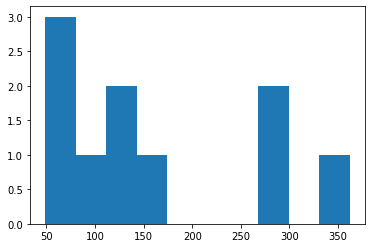

In [32]:
limfoma_data = np.array([49,58,75,110,112,132,151,276,281,362])
pylab.hist(limfoma_data)
pylab.show()

In [33]:
print('95%% confidence interval for the mean time: [%f, %f]' % zconfint(limfoma_data))
print("Критерий знаков                    M: %d, p-value: %f" % sign_test(limfoma_data, 200))
print("Критерий знаковых рангов Вилкоксона:  M: %d, p-value: %f" % stats.wilcoxon(np.array(limfoma_data - 200)))

95% confidence interval for the mean time: [93.808829, 227.391171]
Критерий знаков                    M: -2, p-value: 0.343750
Критерий знаковых рангов Вилкоксона:  M: 17, p-value: 0.284503


In [34]:
data1 = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
data2 = np.array([17,18,18,15,12,4,14,15,10])

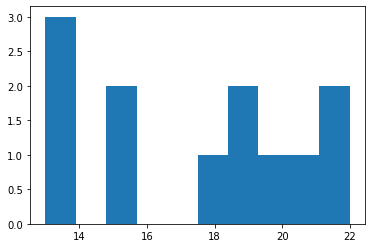

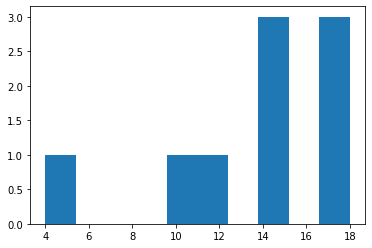

In [35]:
pylab.hist(data1)
pylab.show()
pylab.hist(data2)
pylab.show()

In [36]:
stats.mannwhitneyu(data1, data2, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.02900499272087373)

In [37]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [38]:
ring_data = pd.read_csv('challenger.txt', sep='\t')[['Temperature', 'Incident']]

In [39]:
incident_0 = ring_data[ring_data.Incident == 0].Temperature.values
incident_1 = ring_data[ring_data.Incident == 1].Temperature.values

In [53]:
np.random.seed(0)

incident_0_median_scores = list(map(np.mean, get_bootstrap_samples(incident_0, 1000)))
incident_1_median_scores = list(map(np.mean, get_bootstrap_samples(incident_1, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(incident_0_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(incident_1_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [21.06875  23.575625]
95% confidence interval for the CLEC median repair time: [14.5125     20.71607143]


In [56]:

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(incident_0_median_scores, incident_1_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1.42299107 7.93861607]


In [59]:
np.round(1.4229,3)

1.423

In [42]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [49]:
np.random.seed(0)
print("p-value: %f" % permutation_test(incident_0, incident_1, max_permutations = 10000))

p-value: 0.007000
